# Image Captioning with Attention Mechanism (Bahdenau Attention)

In this Jupyter Notebook, we demonstrate the implementation of an image captioning system using a combination of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) with an attention mechanism. This involves feature extraction from images using the ResNet50 model, followed by caption generation using an RNN decoder that focuses on specific parts of the image through an attention mechanism.

## 1. Setup

Import necessary libraries and configure the environment.

In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pickle
import json
import datetime
import time
import pandas as pd
from tqdm import tqdm
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

## 2. Data Loading and Preprocessing

Load the dataset and prepare it for the model. This includes loading and preprocessing images and captions.


In [3]:
# Load and prepare the data
def load_data(file_path, img_dir):
    with open(file_path, 'r') as f:
        data = json.load(f)['annotations']
    img_cap_pairs = [[f'{sample["image_id"]:012d}.jpg', sample['caption']] for sample in data]
    df = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
    df['image'] = df['image'].apply(lambda x: os.path.join(img_dir, x))
    return df

### Load Training and Validation data images and their captions

In [4]:
train_data_path = './coco2017/annotations/captions_train2017.json'
val_data_path = './coco2017/annotations/captions_val2017.json'
train_img_dir = 'coco2017/train2017'
val_img_dir = 'coco2017/val2017'

df_train = load_data(train_data_path, train_img_dir)
df_valid = load_data(val_data_path, val_img_dir)

### Load and Show Image Functions

In [5]:
# Function to load and preprocess images
def load_image(path, size=(224, 224)):
    img = Image.open(path).resize(size, resample=Image.LANCZOS)
    img = np.array(img) / 255.0
    if len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

def show_image(filename, caption):
    path = filename
    print(caption)
    img = load_image(path)
    plt.imshow(img)
    plt.show()

The airplane is on the runway with two young men standing by.


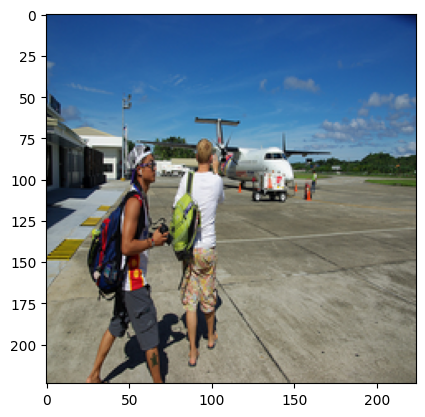

In [6]:
idx = 104
show_image(df_train.image[idx], df_train.caption[idx])

In [7]:
print(f"Training has {df_train.shape[0]} ({df_train.image.nunique()}) records and Validation Dataset has {df_valid.shape[0]}  ({df_valid.image.nunique()})")

Training has 591753 (118287) records and Validation Dataset has 25014  (5000)


## 3. Feature Extraction

Extract features from images using a pre-trained ResNet50 model.

<a id="ResNet50"></a>
### ResNet50 _Custom Model




In [8]:
# Load the ResNet50 model pre-trained on ImageNet data
image_model = ResNet50(include_top=False, weights='imagenet')
image_features_extract_model = Model(inputs=image_model.input, outputs=image_model.layers[-1].output)

2024-06-11 03:13:07.646298: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-11 03:13:07.646354: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-06-11 03:13:07.646365: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-06-11 03:13:07.646429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-11 03:13:07.646457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Data Preprocessing function

In [9]:
# Function to preprocess image paths and extract features
def preprocess_and_extract_features(image_paths,model_name,batch_size=64,):
    def load_image_resnet(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.resnet50.preprocess_input(img)
        return img, image_path

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(load_image_resnet, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            new_path_of_feature = os.path.join(os.path.dirname(path_of_feature) + f"{model_name1}_features.npy", os.path.basename(path_of_feature) + '.npy')
            os.makedirs(os.path.dirname(new_path_of_feature), exist_ok=True)
            np.save(new_path_of_feature, bf.numpy())

### Sample and Data Parameters

In [10]:
# Dataset preparation
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_of_samples=100000
model_name1="Resnet50_GRU2"
features_shape = 2048
attention_features_shape = 49

In [11]:
# Sample data and extract features
df_train_sample = df_train.sample(num_of_samples, random_state=62)
train_filenames_vectors_mini = df_train_sample.image.tolist()
preprocess_and_extract_features(train_filenames_vectors_mini,model_name1)

100%|██████████| 1563/1563 [08:11<00:00,  3.18it/s]


## 4. Tokenization and Dataset Preparation

Tokenize captions and prepare TensorFlow datasets for training.

In [12]:
# Tokenize captions
def tokenize_captions(captions, top_k=10000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(captions)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    sequences = tokenizer.texts_to_sequences(captions)
    cap_vector = pad_sequences(sequences, padding='post')
    return tokenizer, cap_vector

In [13]:
top_k=15000
train_captions_wrapped = ['<start> ' + c + ' <end>' for c in df_train_sample.caption.tolist()]
tokenizer, cap_vector = tokenize_captions(train_captions_wrapped,top_k)
max_length = max(len(t) for t in cap_vector)

In [14]:
max_length

52

In [15]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(train_filenames_vectors_mini, cap_vector, test_size=0.15, random_state=0)

In [16]:
# Load the numpy files
def map_func(img_name, cap):
    name = img_name.decode('utf-8')
    new_name = name[0:name.rindex('/')] + f"{model_name1}_features.npy/" + name[name.rindex('/'):] + '.npy'
    img_tensor = np.load(new_name)
    return img_tensor, cap

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                      map_func, [item1, item2], [tf.float32, tf.int32]), 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 5. Model Architecture and Setup

Define the architecture of the encoder and decoder, including the attention mechanism. We also setup the optimizer and loss function here.


### Bahdanau Attention Class

In [18]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Encoder Class

In [19]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder Class

In [20]:
#RNN Encoder with more GRU Layers
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, num_gru_layers=2):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru_layers = [tf.keras.layers.GRU(self.units,
                                               return_sequences=True,
                                               return_state=True,
                                               recurrent_initializer='glorot_uniform') for _ in range(num_gru_layers)]
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden[-1])

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        states = []
        for gru_layer in self.gru_layers:
            x, state = gru_layer(x)
            states.append(state)

        x = self.fc1(x)
        # Flatten the output for the Dense layer
        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, states, attention_weights

    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)) for _ in self.gru_layers]

### Model Parameters

In [21]:
# Instantiate encoder and decoder
gru_layers = 2
embedding_dim = 256
units = 512
vocab_size = tokenizer.num_words + 1
num_steps = len(img_name_train) // BATCH_SIZE
start_epoch = 0

## 6. Training Operations

Set up the training operations including the optimizer, loss function, and training loop to manage the learning process.


### Optimizer and Loss

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size,gru_layers)

In [22]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [23]:
def loss_function(real, pred):
    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)), dtype=pred.dtype)
    loss_ = loss_object(real, pred)
    loss_ *= mask
    return tf.reduce_mean(loss_)

### Tokenizer and Checkpoints

In [24]:
# Save the tokenizer
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = f"{current_time}_{num_of_samples}_{embedding_dim}_{units}_{vocab_size}_{max_length}_{gru_layers}"
with open(f'artifacts/tokenizer_{model_name}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Setup checkpoints
checkpoint_path = f'checkpoints/bahdanau_{model_name}'
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Model Dimnesions and Layer shapes

In [29]:
loss_plot = []

for (batch, (img_tensor, target)) in enumerate(dataset):
    
    print('img_tensor, target:', img_tensor.shape, target.shape)
    
    #hidden = decoder.reset_state(batch_size=target.shape[0])
    #print('hidden:', hidden.shape)
    hidden = decoder.reset_state(batch_size=target.shape[0])
    for i, h in enumerate(hidden):
        print(f'Hidden state {i}:', h.shape)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    print('dec_input:', dec_input.shape)
    
    features = encoder(img_tensor)
    print('features', features.shape)
    

    # predictions, hidden, junk = decoder(dec_input, features, hidden)
    # print('predictions, hidden, junk:', predictions.shape, hidden.shape, junk.shape)
     
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    print('predictions:', predictions.shape)
    # Iterate over the hidden states list to print each tensor's shape
    for i, h in enumerate(hidden):
        print(f'Hidden state {i}:', h.shape)
    print('Attention weights:', attention_weights.shape)
    
    print('target[:, 1]:', target[:, 1].shape)
    loss = loss_function(target[:, 1], predictions)
    print('loss:', loss.numpy())
    
    dec_input = tf.expand_dims(target[:, 1], 1)
    print('dec_input:', dec_input.shape)
    
    break

img_tensor, target: (64, 49, 2048) (64, 52)
Hidden state 0: (64, 512)
Hidden state 1: (64, 512)
dec_input: (64, 1)
features (64, 49, 256)
predictions: (64, 15001)
Hidden state 0: (64, 512)
Hidden state 1: (64, 512)
Attention weights: (64, 49, 1)
target[:, 1]: (64,)
loss: 9.611067
dec_input: (64, 1)


## 7. Training Loop

The training loop iterates over the dataset, updating the model weights based on the loss gradients, and saves checkpoints periodically.

### Training function

In [30]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### Training

In [31]:
EPOCHS = 1

#### Train 1

In [32]:
%%time
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-11 03:29:30.435365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-11 03:29:32.316880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 1 Batch 0 Loss 2.1585
Epoch 1 Batch 100 Loss 1.2762
Epoch 1 Batch 200 Loss 1.0968
Epoch 1 Batch 300 Loss 0.9859
Epoch 1 Batch 400 Loss 0.9486
Epoch 1 Batch 500 Loss 0.8425
Epoch 1 Batch 600 Loss 0.7857
Epoch 1 Batch 700 Loss 0.8147
Epoch 1 Batch 800 Loss 0.8254
Epoch 1 Batch 900 Loss 0.7595
Epoch 1 Batch 1000 Loss 0.8812
Epoch 1 Batch 1100 Loss 0.7981
Epoch 1 Batch 1200 Loss 0.7589
Epoch 1 Batch 1300 Loss 0.7420


2024-06-11 03:36:49.238474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 1 Loss 0.905576
Time taken for 1 epoch 489.43 sec



100%|██████████| 1/1 [08:09<00:00, 489.74s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-1 at epoch 1
CPU times: user 7min 27s, sys: 1min 44s, total: 9min 11s
Wall time: 8min 9s


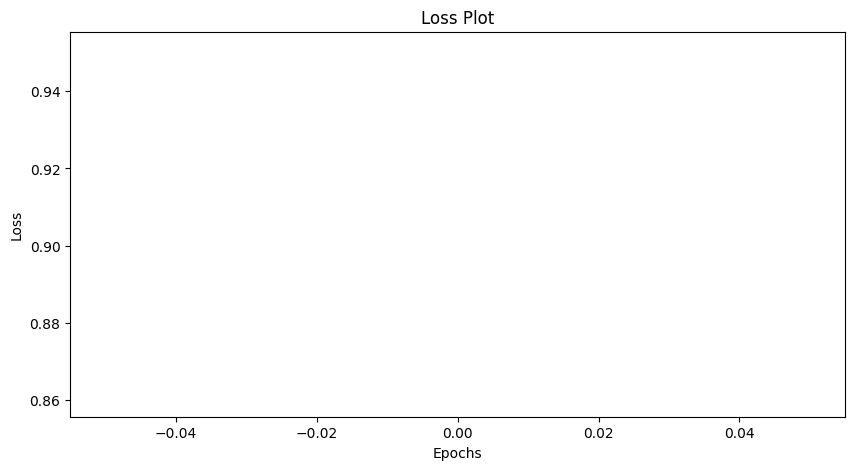

In [33]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 2

In [34]:
%%time
EPOCHS = 3
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.7522
Epoch 1 Batch 100 Loss 0.7451
Epoch 1 Batch 200 Loss 0.7904
Epoch 1 Batch 300 Loss 0.7247
Epoch 1 Batch 400 Loss 0.7199
Epoch 1 Batch 500 Loss 0.6564
Epoch 1 Batch 600 Loss 0.6787
Epoch 1 Batch 700 Loss 0.7032
Epoch 1 Batch 800 Loss 0.6230
Epoch 1 Batch 900 Loss 0.7110
Epoch 1 Batch 1000 Loss 0.6281
Epoch 1 Batch 1100 Loss 0.6450
Epoch 1 Batch 1200 Loss 0.7079
Epoch 1 Batch 1300 Loss 0.8069


 33%|███▎      | 1/3 [06:42<13:24, 402.37s/it]

Epoch 1 Loss 0.693745
Time taken for 1 epoch 402.37 sec

Epoch 2 Batch 0 Loss 0.6636
Epoch 2 Batch 100 Loss 0.6817
Epoch 2 Batch 200 Loss 0.5922
Epoch 2 Batch 300 Loss 0.6522
Epoch 2 Batch 400 Loss 0.6492
Epoch 2 Batch 500 Loss 0.6038
Epoch 2 Batch 600 Loss 0.6086
Epoch 2 Batch 700 Loss 0.6594
Epoch 2 Batch 800 Loss 0.6504
Epoch 2 Batch 900 Loss 0.6124
Epoch 2 Batch 1000 Loss 0.6371
Epoch 2 Batch 1100 Loss 0.6472
Epoch 2 Batch 1200 Loss 0.6356
Epoch 2 Batch 1300 Loss 0.6465


 67%|██████▋   | 2/3 [13:23<06:41, 401.40s/it]

Epoch 2 Loss 0.639592
Time taken for 1 epoch 400.72 sec

Epoch 3 Batch 0 Loss 0.5911
Epoch 3 Batch 100 Loss 0.6036
Epoch 3 Batch 200 Loss 0.6582
Epoch 3 Batch 300 Loss 0.5825
Epoch 3 Batch 400 Loss 0.6268
Epoch 3 Batch 500 Loss 0.6276
Epoch 3 Batch 600 Loss 0.6175
Epoch 3 Batch 700 Loss 0.6163
Epoch 3 Batch 800 Loss 0.6082
Epoch 3 Batch 900 Loss 0.5777
Epoch 3 Batch 1000 Loss 0.6384
Epoch 3 Batch 1100 Loss 0.5718
Epoch 3 Batch 1200 Loss 0.5822
Epoch 3 Batch 1300 Loss 0.6074
Epoch 3 Loss 0.604753
Time taken for 1 epoch 400.45 sec



100%|██████████| 3/3 [20:03<00:00, 401.26s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-2 at epoch 3
CPU times: user 19min 5s, sys: 4min 55s, total: 24min
Wall time: 20min 3s


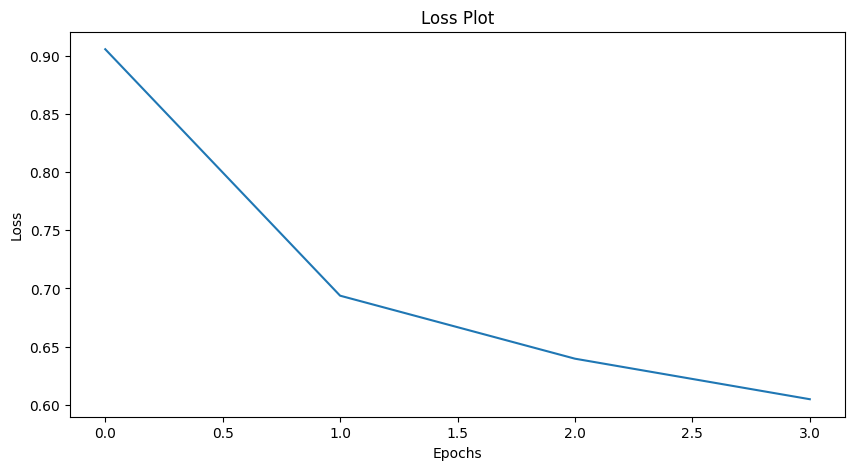

In [35]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 3

In [36]:
%%time
EPOCHS = 3
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.5607
Epoch 1 Batch 100 Loss 0.5719
Epoch 1 Batch 200 Loss 0.6148
Epoch 1 Batch 300 Loss 0.6073
Epoch 1 Batch 400 Loss 0.6123
Epoch 1 Batch 500 Loss 0.5564
Epoch 1 Batch 600 Loss 0.5583
Epoch 1 Batch 700 Loss 0.5662
Epoch 1 Batch 800 Loss 0.5738
Epoch 1 Batch 900 Loss 0.5585
Epoch 1 Batch 1000 Loss 0.5583
Epoch 1 Batch 1100 Loss 0.6152
Epoch 1 Batch 1200 Loss 0.5866
Epoch 1 Batch 1300 Loss 0.5550


 33%|███▎      | 1/3 [06:40<13:21, 400.99s/it]

Epoch 1 Loss 0.576373
Time taken for 1 epoch 400.99 sec

Epoch 2 Batch 0 Loss 0.5542
Epoch 2 Batch 100 Loss 0.5178
Epoch 2 Batch 200 Loss 0.5734
Epoch 2 Batch 300 Loss 0.5365
Epoch 2 Batch 400 Loss 0.5171
Epoch 2 Batch 500 Loss 0.5071
Epoch 2 Batch 600 Loss 0.5514
Epoch 2 Batch 700 Loss 0.5890
Epoch 2 Batch 800 Loss 0.5653
Epoch 2 Batch 900 Loss 0.5509
Epoch 2 Batch 1000 Loss 0.5382
Epoch 2 Batch 1100 Loss 0.5090
Epoch 2 Batch 1200 Loss 0.5335
Epoch 2 Batch 1300 Loss 0.5432


 67%|██████▋   | 2/3 [13:21<06:40, 400.84s/it]

Epoch 2 Loss 0.551170
Time taken for 1 epoch 400.74 sec

Epoch 3 Batch 0 Loss 0.4935
Epoch 3 Batch 100 Loss 0.5145
Epoch 3 Batch 200 Loss 0.5528
Epoch 3 Batch 300 Loss 0.5288
Epoch 3 Batch 400 Loss 0.5177
Epoch 3 Batch 500 Loss 0.4785
Epoch 3 Batch 600 Loss 0.5613
Epoch 3 Batch 700 Loss 0.5473
Epoch 3 Batch 800 Loss 0.5650
Epoch 3 Batch 900 Loss 0.5816
Epoch 3 Batch 1000 Loss 0.4978
Epoch 3 Batch 1100 Loss 0.5230
Epoch 3 Batch 1200 Loss 0.5568
Epoch 3 Batch 1300 Loss 0.5269
Epoch 3 Loss 0.526536
Time taken for 1 epoch 401.27 sec



100%|██████████| 3/3 [20:03<00:00, 401.08s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-3 at epoch 3
CPU times: user 19min 10s, sys: 4min 58s, total: 24min 8s
Wall time: 20min 3s


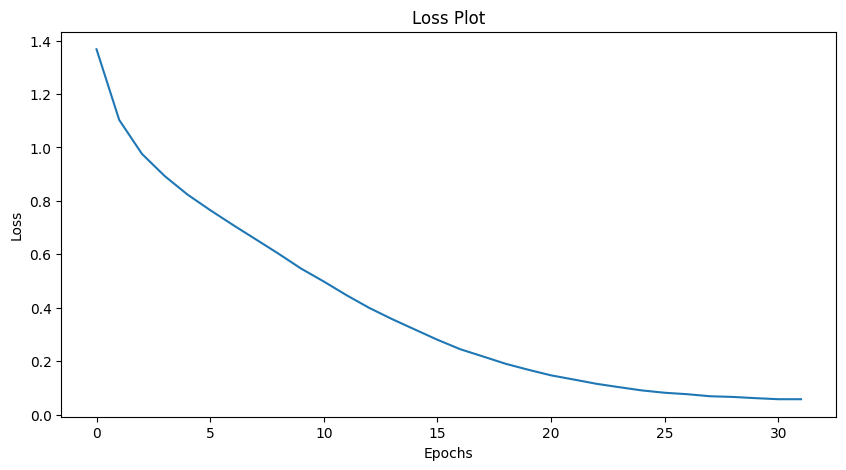

In [36]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 4

In [63]:
%%time
EPOCHS = 10
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.4893
Epoch 1 Batch 100 Loss 0.5269
Epoch 1 Batch 200 Loss 0.5297
Epoch 1 Batch 300 Loss 0.5107
Epoch 1 Batch 400 Loss 0.5391
Epoch 1 Batch 500 Loss 0.4840
Epoch 1 Batch 600 Loss 0.4892
Epoch 1 Batch 700 Loss 0.5274
Epoch 1 Batch 800 Loss 0.5116
Epoch 1 Batch 900 Loss 0.5946
Epoch 1 Batch 1000 Loss 0.5199
Epoch 1 Batch 1100 Loss 0.5378
Epoch 1 Batch 1200 Loss 0.4946
Epoch 1 Batch 1300 Loss 0.4770


 10%|█         | 1/10 [06:41<1:00:09, 401.08s/it]

Epoch 1 Loss 0.505248
Time taken for 1 epoch 401.08 sec

Epoch 2 Batch 0 Loss 0.4548
Epoch 2 Batch 100 Loss 0.5021
Epoch 2 Batch 200 Loss 0.4793
Epoch 2 Batch 300 Loss 0.4597
Epoch 2 Batch 400 Loss 0.5174
Epoch 2 Batch 500 Loss 0.4989
Epoch 2 Batch 600 Loss 0.4570
Epoch 2 Batch 700 Loss 0.4948
Epoch 2 Batch 800 Loss 0.5120
Epoch 2 Batch 900 Loss 0.4998
Epoch 2 Batch 1000 Loss 0.4917
Epoch 2 Batch 1100 Loss 0.5154
Epoch 2 Batch 1200 Loss 0.5096
Epoch 2 Batch 1300 Loss 0.4555


 20%|██        | 2/10 [13:23<53:33, 401.65s/it]  

Epoch 2 Loss 0.485535
Time taken for 1 epoch 402.05 sec

Epoch 3 Batch 0 Loss 0.4908
Epoch 3 Batch 100 Loss 0.4666
Epoch 3 Batch 200 Loss 0.4415
Epoch 3 Batch 300 Loss 0.4834
Epoch 3 Batch 400 Loss 0.4888
Epoch 3 Batch 500 Loss 0.4562
Epoch 3 Batch 600 Loss 0.4308
Epoch 3 Batch 700 Loss 0.4983
Epoch 3 Batch 800 Loss 0.4470
Epoch 3 Batch 900 Loss 0.4774
Epoch 3 Batch 1000 Loss 0.4444
Epoch 3 Batch 1100 Loss 0.4542
Epoch 3 Batch 1200 Loss 0.4065
Epoch 3 Batch 1300 Loss 0.4090


 30%|███       | 3/10 [20:01<46:39, 399.96s/it]

Epoch 3 Loss 0.463639
Time taken for 1 epoch 397.96 sec

Epoch 4 Batch 0 Loss 0.4752
Epoch 4 Batch 100 Loss 0.4647
Epoch 4 Batch 200 Loss 0.4281
Epoch 4 Batch 300 Loss 0.4768
Epoch 4 Batch 400 Loss 0.4563
Epoch 4 Batch 500 Loss 0.4371
Epoch 4 Batch 600 Loss 0.4043
Epoch 4 Batch 700 Loss 0.4435
Epoch 4 Batch 800 Loss 0.4148
Epoch 4 Batch 900 Loss 0.4711
Epoch 4 Batch 1000 Loss 0.4878
Epoch 4 Batch 1100 Loss 0.4439
Epoch 4 Batch 1200 Loss 0.4523
Epoch 4 Batch 1300 Loss 0.5112


 40%|████      | 4/10 [26:42<40:03, 400.58s/it]

Epoch 4 Loss 0.446054
Time taken for 1 epoch 401.52 sec

Epoch 5 Batch 0 Loss 0.4531
Epoch 5 Batch 100 Loss 0.4816
Epoch 5 Batch 200 Loss 0.4213
Epoch 5 Batch 300 Loss 0.4610
Epoch 5 Batch 400 Loss 0.4523
Epoch 5 Batch 500 Loss 0.4472
Epoch 5 Batch 600 Loss 0.3849
Epoch 5 Batch 700 Loss 0.4347
Epoch 5 Batch 800 Loss 0.4151
Epoch 5 Batch 900 Loss 0.3744
Epoch 5 Batch 1000 Loss 0.3987
Epoch 5 Batch 1100 Loss 0.4388
Epoch 5 Batch 1200 Loss 0.4181
Epoch 5 Batch 1300 Loss 0.4475
Epoch 5 Loss 0.428399
Time taken for 1 epoch 398.84 sec



 50%|█████     | 5/10 [33:21<33:20, 400.03s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-4 at epoch 5
Epoch 6 Batch 0 Loss 0.4361
Epoch 6 Batch 100 Loss 0.4560
Epoch 6 Batch 200 Loss 0.4130
Epoch 6 Batch 300 Loss 0.4207
Epoch 6 Batch 400 Loss 0.4258
Epoch 6 Batch 500 Loss 0.4231
Epoch 6 Batch 600 Loss 0.4169
Epoch 6 Batch 700 Loss 0.4134
Epoch 6 Batch 800 Loss 0.4243
Epoch 6 Batch 900 Loss 0.4043
Epoch 6 Batch 1000 Loss 0.4574
Epoch 6 Batch 1100 Loss 0.4367
Epoch 6 Batch 1200 Loss 0.4022
Epoch 6 Batch 1300 Loss 0.3858


 60%|██████    | 6/10 [48:31<38:12, 573.21s/it]

Epoch 6 Loss 0.411972
Time taken for 1 epoch 909.37 sec

Epoch 7 Batch 0 Loss 0.4066
Epoch 7 Batch 100 Loss 0.4116
Epoch 7 Batch 200 Loss 0.3550
Epoch 7 Batch 300 Loss 0.4275
Epoch 7 Batch 400 Loss 0.4222
Epoch 7 Batch 500 Loss 0.3684
Epoch 7 Batch 600 Loss 0.3881
Epoch 7 Batch 700 Loss 0.4377
Epoch 7 Batch 800 Loss 0.4054
Epoch 7 Batch 900 Loss 0.4630
Epoch 7 Batch 1000 Loss 0.4518
Epoch 7 Batch 1100 Loss 0.4015
Epoch 7 Batch 1200 Loss 0.4383
Epoch 7 Batch 1300 Loss 0.4059


 70%|███████   | 7/10 [55:12<25:51, 517.12s/it]

Epoch 7 Loss 0.407748
Time taken for 1 epoch 401.65 sec

Epoch 8 Batch 0 Loss 0.4285
Epoch 8 Batch 100 Loss 0.4135
Epoch 8 Batch 200 Loss 0.4051
Epoch 8 Batch 300 Loss 0.4001
Epoch 8 Batch 400 Loss 0.4051
Epoch 8 Batch 500 Loss 0.3558
Epoch 8 Batch 600 Loss 0.3418
Epoch 8 Batch 700 Loss 0.4086
Epoch 8 Batch 800 Loss 0.3455
Epoch 8 Batch 900 Loss 0.4150
Epoch 8 Batch 1000 Loss 0.3754
Epoch 8 Batch 1100 Loss 0.3261
Epoch 8 Batch 1200 Loss 0.3824
Epoch 8 Batch 1300 Loss 0.3521


 80%|████████  | 8/10 [1:01:54<16:00, 480.49s/it]

Epoch 8 Loss 0.386315
Time taken for 1 epoch 402.07 sec

Epoch 9 Batch 0 Loss 0.3770
Epoch 9 Batch 100 Loss 0.4211
Epoch 9 Batch 200 Loss 0.3677
Epoch 9 Batch 300 Loss 0.4005
Epoch 9 Batch 400 Loss 0.3463
Epoch 9 Batch 500 Loss 0.3481
Epoch 9 Batch 600 Loss 0.3422
Epoch 9 Batch 700 Loss 0.3877
Epoch 9 Batch 800 Loss 0.3763
Epoch 9 Batch 900 Loss 0.3612
Epoch 9 Batch 1000 Loss 0.3992
Epoch 9 Batch 1100 Loss 0.3683
Epoch 9 Batch 1200 Loss 0.3687
Epoch 9 Batch 1300 Loss 0.3546


 90%|█████████ | 9/10 [1:08:35<07:35, 455.65s/it]

Epoch 9 Loss 0.369808
Time taken for 1 epoch 401.01 sec

Epoch 10 Batch 0 Loss 0.4128
Epoch 10 Batch 100 Loss 0.3631
Epoch 10 Batch 200 Loss 0.3432
Epoch 10 Batch 300 Loss 0.3426
Epoch 10 Batch 400 Loss 0.3689
Epoch 10 Batch 500 Loss 0.3441
Epoch 10 Batch 600 Loss 0.4088
Epoch 10 Batch 700 Loss 0.3776
Epoch 10 Batch 800 Loss 0.3286
Epoch 10 Batch 900 Loss 0.3417
Epoch 10 Batch 1000 Loss 0.3316
Epoch 10 Batch 1100 Loss 0.3488
Epoch 10 Batch 1200 Loss 0.3740
Epoch 10 Batch 1300 Loss 0.3440
Epoch 10 Loss 0.358264
Time taken for 1 epoch 402.37 sec



100%|██████████| 10/10 [1:15:18<00:00, 451.84s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-5 at epoch 10
CPU times: user 1h 4min 22s, sys: 16min 59s, total: 1h 21min 22s
Wall time: 1h 15min 18s


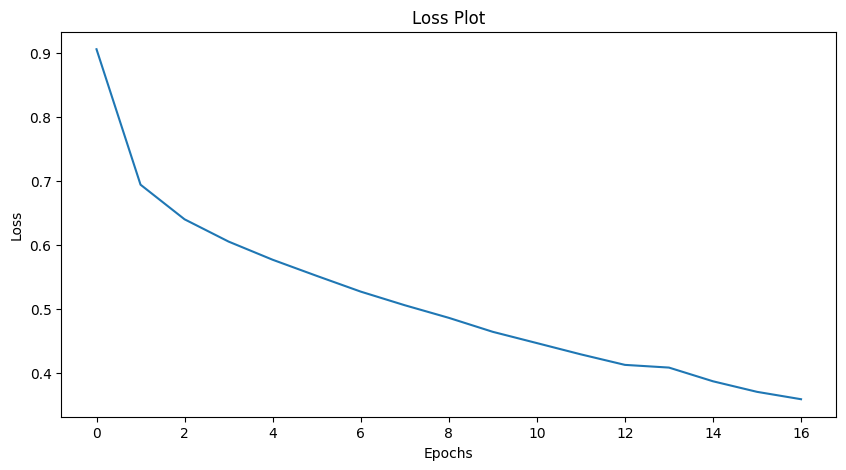

In [64]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 5

In [72]:
%%time
EPOCHS = 15
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.3512
Epoch 1 Batch 100 Loss 0.3736
Epoch 1 Batch 200 Loss 0.3406
Epoch 1 Batch 300 Loss 0.3763
Epoch 1 Batch 400 Loss 0.3511
Epoch 1 Batch 500 Loss 0.3255
Epoch 1 Batch 600 Loss 0.3211
Epoch 1 Batch 700 Loss 0.3779
Epoch 1 Batch 800 Loss 0.3494
Epoch 1 Batch 900 Loss 0.3568
Epoch 1 Batch 1000 Loss 0.3367
Epoch 1 Batch 1100 Loss 0.3471
Epoch 1 Batch 1200 Loss 0.3701
Epoch 1 Batch 1300 Loss 0.3229


  7%|▋         | 1/15 [06:41<1:33:46, 401.86s/it]

Epoch 1 Loss 0.355558
Time taken for 1 epoch 401.86 sec

Epoch 2 Batch 0 Loss 0.3912
Epoch 2 Batch 100 Loss 0.3191
Epoch 2 Batch 200 Loss 0.3540
Epoch 2 Batch 300 Loss 0.3280
Epoch 2 Batch 400 Loss 0.3121
Epoch 2 Batch 500 Loss 0.3006
Epoch 2 Batch 600 Loss 0.3155
Epoch 2 Batch 700 Loss 0.3805
Epoch 2 Batch 800 Loss 0.3635
Epoch 2 Batch 900 Loss 0.3665
Epoch 2 Batch 1000 Loss 0.3298
Epoch 2 Batch 1100 Loss 0.3668
Epoch 2 Batch 1200 Loss 0.3277
Epoch 2 Batch 1300 Loss 0.3357


 13%|█▎        | 2/15 [13:25<1:27:18, 402.97s/it]

Epoch 2 Loss 0.340569
Time taken for 1 epoch 403.75 sec

Epoch 3 Batch 0 Loss 0.3621
Epoch 3 Batch 100 Loss 0.3182
Epoch 3 Batch 200 Loss 0.3697
Epoch 3 Batch 300 Loss 0.3021
Epoch 3 Batch 400 Loss 0.3368
Epoch 3 Batch 500 Loss 0.3281
Epoch 3 Batch 600 Loss 0.3564
Epoch 3 Batch 700 Loss 0.3286
Epoch 3 Batch 800 Loss 0.3555
Epoch 3 Batch 900 Loss 0.3817
Epoch 3 Batch 1000 Loss 0.3269
Epoch 3 Batch 1100 Loss 0.3058
Epoch 3 Batch 1200 Loss 0.3383
Epoch 3 Batch 1300 Loss 0.2978


 20%|██        | 3/15 [20:02<1:20:04, 400.36s/it]

Epoch 3 Loss 0.329993
Time taken for 1 epoch 397.25 sec

Epoch 4 Batch 0 Loss 0.3457
Epoch 4 Batch 100 Loss 0.3686
Epoch 4 Batch 200 Loss 0.2903
Epoch 4 Batch 300 Loss 0.3326
Epoch 4 Batch 400 Loss 0.3101
Epoch 4 Batch 500 Loss 0.2862
Epoch 4 Batch 600 Loss 0.3237
Epoch 4 Batch 700 Loss 0.3604
Epoch 4 Batch 800 Loss 0.2879
Epoch 4 Batch 900 Loss 0.4005
Epoch 4 Batch 1000 Loss 0.3212
Epoch 4 Batch 1100 Loss 0.3143
Epoch 4 Batch 1200 Loss 0.3091
Epoch 4 Batch 1300 Loss 0.3011


 27%|██▋       | 4/15 [1:31:23<5:54:14, 1932.26s/it]

Epoch 4 Loss 0.320358
Time taken for 1 epoch 4280.65 sec

Epoch 5 Batch 0 Loss 0.3269
Epoch 5 Batch 100 Loss 0.2982
Epoch 5 Batch 200 Loss 0.3300
Epoch 5 Batch 300 Loss 0.3251
Epoch 5 Batch 400 Loss 0.3070
Epoch 5 Batch 500 Loss 0.3080
Epoch 5 Batch 600 Loss 0.2968
Epoch 5 Batch 700 Loss 0.3630
Epoch 5 Batch 800 Loss 0.3373
Epoch 5 Batch 900 Loss 0.3028
Epoch 5 Batch 1000 Loss 0.3113
Epoch 5 Batch 1100 Loss 0.3104
Epoch 5 Batch 1200 Loss 0.2925
Epoch 5 Batch 1300 Loss 0.3269
Epoch 5 Loss 0.312212
Time taken for 1 epoch 1353.39 sec



 33%|███▎      | 5/15 [1:53:57<4:47:16, 1723.60s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-6 at epoch 5
Epoch 6 Batch 0 Loss 0.3326
Epoch 6 Batch 100 Loss 0.5406
Epoch 6 Batch 200 Loss 0.3857
Epoch 6 Batch 300 Loss 0.3400
Epoch 6 Batch 400 Loss 0.3436
Epoch 6 Batch 500 Loss 0.3228
Epoch 6 Batch 600 Loss 0.3075
Epoch 6 Batch 700 Loss 0.3689
Epoch 6 Batch 800 Loss 0.3181
Epoch 6 Batch 900 Loss 0.2982
Epoch 6 Batch 1000 Loss 0.3226
Epoch 6 Batch 1100 Loss 0.3402
Epoch 6 Batch 1200 Loss 0.2887
Epoch 6 Batch 1300 Loss 0.3140


 40%|████      | 6/15 [2:00:36<3:11:00, 1273.36s/it]

Epoch 6 Loss 0.327421
Time taken for 1 epoch 399.35 sec

Epoch 7 Batch 0 Loss 0.3148
Epoch 7 Batch 100 Loss 0.2833
Epoch 7 Batch 200 Loss 0.3132
Epoch 7 Batch 300 Loss 0.3243
Epoch 7 Batch 400 Loss 0.2985
Epoch 7 Batch 500 Loss 0.3013
Epoch 7 Batch 600 Loss 0.3028
Epoch 7 Batch 700 Loss 0.3496
Epoch 7 Batch 800 Loss 0.3321
Epoch 7 Batch 900 Loss 0.2774
Epoch 7 Batch 1000 Loss 0.2523
Epoch 7 Batch 1100 Loss 0.2920
Epoch 7 Batch 1200 Loss 0.3194
Epoch 7 Batch 1300 Loss 0.3317


 47%|████▋     | 7/15 [2:16:38<2:36:12, 1171.54s/it]

Epoch 7 Loss 0.303267
Time taken for 1 epoch 961.90 sec

Epoch 8 Batch 0 Loss 0.3092
Epoch 8 Batch 100 Loss 0.2915
Epoch 8 Batch 200 Loss 0.3436
Epoch 8 Batch 300 Loss 0.2970
Epoch 8 Batch 400 Loss 0.2674
Epoch 8 Batch 500 Loss 0.2947
Epoch 8 Batch 600 Loss 0.2536
Epoch 8 Batch 700 Loss 0.2984
Epoch 8 Batch 800 Loss 0.2827
Epoch 8 Batch 900 Loss 0.2738
Epoch 8 Batch 1000 Loss 0.3193
Epoch 8 Batch 1100 Loss 0.3026
Epoch 8 Batch 1200 Loss 0.2896
Epoch 8 Batch 1300 Loss 0.2609


 53%|█████▎    | 8/15 [2:23:19<1:48:03, 926.23s/it] 

Epoch 8 Loss 0.293858
Time taken for 1 epoch 401.00 sec

Epoch 9 Batch 0 Loss 0.3028
Epoch 9 Batch 100 Loss 0.2944
Epoch 9 Batch 200 Loss 0.3037
Epoch 9 Batch 300 Loss 0.2971
Epoch 9 Batch 400 Loss 0.3200
Epoch 9 Batch 500 Loss 0.2754
Epoch 9 Batch 600 Loss 0.2467
Epoch 9 Batch 700 Loss 0.3108
Epoch 9 Batch 800 Loss 0.3104
Epoch 9 Batch 900 Loss 0.2656
Epoch 9 Batch 1000 Loss 0.2994
Epoch 9 Batch 1100 Loss 0.2862
Epoch 9 Batch 1200 Loss 0.2893
Epoch 9 Batch 1300 Loss 0.3053


 60%|██████    | 9/15 [2:30:01<1:16:13, 762.26s/it]

Epoch 9 Loss 0.287385
Time taken for 1 epoch 401.72 sec

Epoch 10 Batch 0 Loss 0.3140
Epoch 10 Batch 100 Loss 0.2932
Epoch 10 Batch 200 Loss 0.2942
Epoch 10 Batch 300 Loss 0.3241
Epoch 10 Batch 400 Loss 0.2711
Epoch 10 Batch 500 Loss 0.2990
Epoch 10 Batch 600 Loss 0.3044
Epoch 10 Batch 700 Loss 0.2642
Epoch 10 Batch 800 Loss 0.2710
Epoch 10 Batch 900 Loss 0.2969
Epoch 10 Batch 1000 Loss 0.2970
Epoch 10 Batch 1100 Loss 0.2528
Epoch 10 Batch 1200 Loss 0.2699
Epoch 10 Batch 1300 Loss 0.3086
Epoch 10 Loss 0.283990
Time taken for 1 epoch 401.37 sec



 67%|██████▋   | 10/15 [2:36:42<54:14, 650.92s/it] 

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-7 at epoch 10
Epoch 11 Batch 0 Loss 0.2663
Epoch 11 Batch 100 Loss 0.3095
Epoch 11 Batch 200 Loss 0.3138
Epoch 11 Batch 300 Loss 0.2968
Epoch 11 Batch 400 Loss 0.2850
Epoch 11 Batch 500 Loss 0.2842
Epoch 11 Batch 600 Loss 0.2696
Epoch 11 Batch 700 Loss 0.2808
Epoch 11 Batch 800 Loss 0.2974
Epoch 11 Batch 900 Loss 0.2717
Epoch 11 Batch 1000 Loss 0.2729
Epoch 11 Batch 1100 Loss 0.2761
Epoch 11 Batch 1200 Loss 0.2683
Epoch 11 Batch 1300 Loss 0.2641


 73%|███████▎  | 11/15 [2:43:23<38:17, 574.27s/it]

Epoch 11 Loss 0.277272
Time taken for 1 epoch 400.48 sec

Epoch 12 Batch 0 Loss 0.2580
Epoch 12 Batch 100 Loss 0.2736
Epoch 12 Batch 200 Loss 0.3004
Epoch 12 Batch 300 Loss 0.2563
Epoch 12 Batch 400 Loss 0.2727
Epoch 12 Batch 500 Loss 0.2600
Epoch 12 Batch 600 Loss 0.2861
Epoch 12 Batch 700 Loss 0.2924
Epoch 12 Batch 800 Loss 0.2854
Epoch 12 Batch 900 Loss 0.3078
Epoch 12 Batch 1000 Loss 0.2563
Epoch 12 Batch 1100 Loss 0.2716
Epoch 12 Batch 1200 Loss 0.2481
Epoch 12 Batch 1300 Loss 0.2622


 80%|████████  | 12/15 [2:50:08<26:08, 522.75s/it]

Epoch 12 Loss 0.275735
Time taken for 1 epoch 404.91 sec

Epoch 13 Batch 0 Loss 0.2757
Epoch 13 Batch 100 Loss 0.3152
Epoch 13 Batch 200 Loss 0.2925
Epoch 13 Batch 300 Loss 0.2715
Epoch 13 Batch 400 Loss 0.3112
Epoch 13 Batch 500 Loss 0.2663
Epoch 13 Batch 600 Loss 0.2577
Epoch 13 Batch 700 Loss 0.2698
Epoch 13 Batch 800 Loss 0.2646
Epoch 13 Batch 900 Loss 0.2702
Epoch 13 Batch 1000 Loss 0.2756
Epoch 13 Batch 1100 Loss 0.2610
Epoch 13 Batch 1200 Loss 0.2871
Epoch 13 Batch 1300 Loss 0.2527


 87%|████████▋ | 13/15 [2:56:45<16:09, 484.77s/it]

Epoch 13 Loss 0.271038
Time taken for 1 epoch 397.39 sec

Epoch 14 Batch 0 Loss 0.2722
Epoch 14 Batch 100 Loss 0.2483
Epoch 14 Batch 200 Loss 0.2581
Epoch 14 Batch 300 Loss 0.2586
Epoch 14 Batch 400 Loss 0.2776
Epoch 14 Batch 500 Loss 0.2489
Epoch 14 Batch 600 Loss 0.2300
Epoch 14 Batch 700 Loss 0.2874
Epoch 14 Batch 800 Loss 0.2423
Epoch 14 Batch 900 Loss 0.2490
Epoch 14 Batch 1000 Loss 0.2715
Epoch 14 Batch 1100 Loss 0.2385
Epoch 14 Batch 1200 Loss 0.2907
Epoch 14 Batch 1300 Loss 0.2403


 93%|█████████▎| 14/15 [3:03:26<07:39, 459.43s/it]

Epoch 14 Loss 0.261570
Time taken for 1 epoch 400.87 sec

Epoch 15 Batch 0 Loss 0.2582
Epoch 15 Batch 100 Loss 0.2408
Epoch 15 Batch 200 Loss 0.2891
Epoch 15 Batch 300 Loss 0.2431
Epoch 15 Batch 400 Loss 0.2883
Epoch 15 Batch 500 Loss 0.2487
Epoch 15 Batch 600 Loss 0.2365
Epoch 15 Batch 700 Loss 0.2594
Epoch 15 Batch 800 Loss 0.2789
Epoch 15 Batch 900 Loss 0.2647
Epoch 15 Batch 1000 Loss 0.2538
Epoch 15 Batch 1100 Loss 0.2572
Epoch 15 Batch 1200 Loss 0.2671
Epoch 15 Batch 1300 Loss 0.2209
Epoch 15 Loss 0.258596
Time taken for 1 epoch 396.41 sec



100%|██████████| 15/15 [3:10:03<00:00, 760.20s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-8 at epoch 15
CPU times: user 1h 36min 2s, sys: 25min 5s, total: 2h 1min 7s
Wall time: 3h 10min 3s


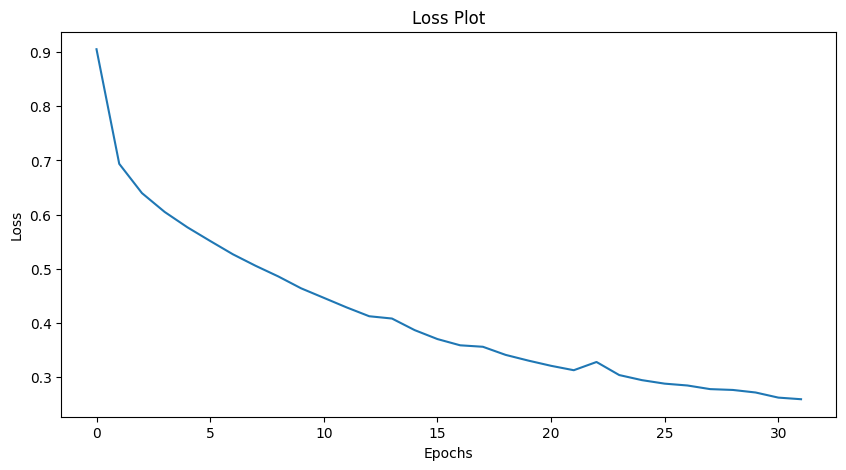

In [73]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 6

In [82]:
%%time
EPOCHS = 15
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.2682
Epoch 1 Batch 100 Loss 0.2549
Epoch 1 Batch 200 Loss 0.2242
Epoch 1 Batch 300 Loss 0.2541
Epoch 1 Batch 400 Loss 0.2504
Epoch 1 Batch 500 Loss 0.2400
Epoch 1 Batch 600 Loss 0.2217
Epoch 1 Batch 700 Loss 0.2645
Epoch 1 Batch 800 Loss 0.2449
Epoch 1 Batch 900 Loss 0.2544
Epoch 1 Batch 1000 Loss 0.2487
Epoch 1 Batch 1100 Loss 0.2702
Epoch 1 Batch 1200 Loss 0.2692
Epoch 1 Batch 1300 Loss 0.2567


  7%|▋         | 1/15 [06:41<1:33:46, 401.87s/it]

Epoch 1 Loss 0.253007
Time taken for 1 epoch 401.87 sec

Epoch 2 Batch 0 Loss 0.2705
Epoch 2 Batch 100 Loss 0.2660
Epoch 2 Batch 200 Loss 0.2816
Epoch 2 Batch 300 Loss 0.2568
Epoch 2 Batch 400 Loss 0.2755
Epoch 2 Batch 500 Loss 0.2531
Epoch 2 Batch 600 Loss 0.2403
Epoch 2 Batch 700 Loss 0.2378
Epoch 2 Batch 800 Loss 0.2744
Epoch 2 Batch 900 Loss 0.2576
Epoch 2 Batch 1000 Loss 0.2154
Epoch 2 Batch 1100 Loss 0.2395
Epoch 2 Batch 1200 Loss 0.3034
Epoch 2 Batch 1300 Loss 0.2617


 13%|█▎        | 2/15 [21:17<2:27:27, 680.61s/it]

Epoch 2 Loss 0.261284
Time taken for 1 epoch 875.74 sec

Epoch 3 Batch 0 Loss 0.3030
Epoch 3 Batch 100 Loss 0.2272
Epoch 3 Batch 200 Loss 0.2602
Epoch 3 Batch 300 Loss 0.2187
Epoch 3 Batch 400 Loss 0.2576
Epoch 3 Batch 500 Loss 0.2377
Epoch 3 Batch 600 Loss 0.2460
Epoch 3 Batch 700 Loss 0.2616
Epoch 3 Batch 800 Loss 0.2437
Epoch 3 Batch 900 Loss 0.2359
Epoch 3 Batch 1000 Loss 0.2415
Epoch 3 Batch 1100 Loss 0.2292
Epoch 3 Batch 1200 Loss 0.2415
Epoch 3 Batch 1300 Loss 0.2181


 20%|██        | 3/15 [1:08:46<5:34:06, 1670.56s/it]

Epoch 3 Loss 0.247916
Time taken for 1 epoch 2848.58 sec

Epoch 4 Batch 0 Loss 0.2426
Epoch 4 Batch 100 Loss 0.2440
Epoch 4 Batch 200 Loss 0.2456
Epoch 4 Batch 300 Loss 0.2611
Epoch 4 Batch 400 Loss 0.2214
Epoch 4 Batch 500 Loss 0.2431
Epoch 4 Batch 600 Loss 0.2547
Epoch 4 Batch 700 Loss 0.2565
Epoch 4 Batch 800 Loss 0.2145
Epoch 4 Batch 900 Loss 0.2548
Epoch 4 Batch 1000 Loss 0.2616
Epoch 4 Batch 1100 Loss 0.2172
Epoch 4 Batch 1200 Loss 0.2636
Epoch 4 Batch 1300 Loss 0.2389


 27%|██▋       | 4/15 [1:16:37<3:39:27, 1197.07s/it]

Epoch 4 Loss 0.242295
Time taken for 1 epoch 471.21 sec

Epoch 5 Batch 0 Loss 0.2632
Epoch 5 Batch 100 Loss 0.2500
Epoch 5 Batch 200 Loss 0.2321
Epoch 5 Batch 300 Loss 0.2379
Epoch 5 Batch 400 Loss 0.2443
Epoch 5 Batch 500 Loss 0.2417
Epoch 5 Batch 600 Loss 0.2337
Epoch 5 Batch 700 Loss 0.2524
Epoch 5 Batch 800 Loss 0.2270
Epoch 5 Batch 900 Loss 0.2309
Epoch 5 Batch 1000 Loss 0.2201
Epoch 5 Batch 1100 Loss 0.2497
Epoch 5 Batch 1200 Loss 0.2438
Epoch 5 Batch 1300 Loss 0.2265
Epoch 5 Loss 0.241337
Time taken for 1 epoch 402.04 sec



 33%|███▎      | 5/15 [1:23:19<2:31:44, 910.47s/it] 

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-9 at epoch 5
Epoch 6 Batch 0 Loss 0.2221
Epoch 6 Batch 100 Loss 0.2649
Epoch 6 Batch 200 Loss 0.2066
Epoch 6 Batch 300 Loss 0.2517
Epoch 6 Batch 400 Loss 0.2443
Epoch 6 Batch 500 Loss 0.2067
Epoch 6 Batch 600 Loss 0.2209
Epoch 6 Batch 700 Loss 0.2344
Epoch 6 Batch 800 Loss 0.2492
Epoch 6 Batch 900 Loss 0.2083
Epoch 6 Batch 1000 Loss 0.2562
Epoch 6 Batch 1100 Loss 0.2320
Epoch 6 Batch 1200 Loss 0.2461
Epoch 6 Batch 1300 Loss 0.2248


 40%|████      | 6/15 [1:30:05<1:50:48, 738.77s/it]

Epoch 6 Loss 0.236129
Time taken for 1 epoch 405.49 sec

Epoch 7 Batch 0 Loss 0.2420
Epoch 7 Batch 100 Loss 0.2336
Epoch 7 Batch 200 Loss 0.2412
Epoch 7 Batch 300 Loss 0.2748
Epoch 7 Batch 400 Loss 0.2490
Epoch 7 Batch 500 Loss 0.2380
Epoch 7 Batch 600 Loss 0.2224
Epoch 7 Batch 700 Loss 0.2659
Epoch 7 Batch 800 Loss 0.2545
Epoch 7 Batch 900 Loss 0.2875
Epoch 7 Batch 1000 Loss 0.2589
Epoch 7 Batch 1100 Loss 0.2385
Epoch 7 Batch 1200 Loss 0.3054
Epoch 7 Batch 1300 Loss 0.2392


 47%|████▋     | 7/15 [1:36:48<1:23:53, 629.15s/it]

Epoch 7 Loss 0.255294
Time taken for 1 epoch 403.46 sec

Epoch 8 Batch 0 Loss 0.2249
Epoch 8 Batch 100 Loss 0.2792
Epoch 8 Batch 200 Loss 0.2393
Epoch 8 Batch 300 Loss 0.2485
Epoch 8 Batch 400 Loss 0.2518
Epoch 8 Batch 500 Loss 0.2203
Epoch 8 Batch 600 Loss 0.2381
Epoch 8 Batch 700 Loss 0.2152
Epoch 8 Batch 800 Loss 0.2503
Epoch 8 Batch 900 Loss 0.2479
Epoch 8 Batch 1000 Loss 0.2264
Epoch 8 Batch 1100 Loss 0.2396
Epoch 8 Batch 1200 Loss 0.2561
Epoch 8 Batch 1300 Loss 0.2468


 53%|█████▎    | 8/15 [1:43:32<1:05:03, 557.58s/it]

Epoch 8 Loss 0.239385
Time taken for 1 epoch 404.34 sec

Epoch 9 Batch 0 Loss 0.2345
Epoch 9 Batch 100 Loss 0.2273
Epoch 9 Batch 200 Loss 0.2395
Epoch 9 Batch 300 Loss 0.2264
Epoch 9 Batch 400 Loss 0.2188
Epoch 9 Batch 500 Loss 0.2153
Epoch 9 Batch 600 Loss 0.1840
Epoch 9 Batch 700 Loss 0.2182
Epoch 9 Batch 800 Loss 0.2127
Epoch 9 Batch 900 Loss 0.2600
Epoch 9 Batch 1000 Loss 0.2387
Epoch 9 Batch 1100 Loss 0.2173
Epoch 9 Batch 1200 Loss 0.2562
Epoch 9 Batch 1300 Loss 0.2434


 60%|██████    | 9/15 [1:50:17<50:58, 509.76s/it]  

Epoch 9 Loss 0.233171
Time taken for 1 epoch 404.62 sec

Epoch 10 Batch 0 Loss 0.2589
Epoch 10 Batch 100 Loss 0.2712
Epoch 10 Batch 200 Loss 0.2305
Epoch 10 Batch 300 Loss 0.2363
Epoch 10 Batch 400 Loss 0.2374
Epoch 10 Batch 500 Loss 0.2410
Epoch 10 Batch 600 Loss 0.2243
Epoch 10 Batch 700 Loss 0.2192
Epoch 10 Batch 800 Loss 0.2343
Epoch 10 Batch 900 Loss 0.2498
Epoch 10 Batch 1000 Loss 0.2177
Epoch 10 Batch 1100 Loss 0.2442
Epoch 10 Batch 1200 Loss 0.2056
Epoch 10 Batch 1300 Loss 0.2134
Epoch 10 Loss 0.233053
Time taken for 1 epoch 407.02 sec



 67%|██████▋   | 10/15 [1:57:04<39:50, 478.12s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-10 at epoch 10
Epoch 11 Batch 0 Loss 0.2416
Epoch 11 Batch 100 Loss 0.2339
Epoch 11 Batch 200 Loss 0.2379
Epoch 11 Batch 300 Loss 0.2033
Epoch 11 Batch 400 Loss 0.2499
Epoch 11 Batch 500 Loss 0.2418
Epoch 11 Batch 600 Loss 0.2324
Epoch 11 Batch 700 Loss 0.2247
Epoch 11 Batch 800 Loss 0.2195
Epoch 11 Batch 900 Loss 0.2596
Epoch 11 Batch 1000 Loss 0.2175
Epoch 11 Batch 1100 Loss 0.2011
Epoch 11 Batch 1200 Loss 0.1984
Epoch 11 Batch 1300 Loss 0.2181


 73%|███████▎  | 11/15 [2:03:47<30:20, 455.06s/it]

Epoch 11 Loss 0.232094
Time taken for 1 epoch 402.79 sec

Epoch 12 Batch 0 Loss 0.2548
Epoch 12 Batch 100 Loss 0.2161
Epoch 12 Batch 200 Loss 0.2147
Epoch 12 Batch 300 Loss 0.2174
Epoch 12 Batch 400 Loss 0.2376
Epoch 12 Batch 500 Loss 0.2165
Epoch 12 Batch 600 Loss 0.2129
Epoch 12 Batch 700 Loss 0.2249
Epoch 12 Batch 800 Loss 0.2011
Epoch 12 Batch 900 Loss 0.2288
Epoch 12 Batch 1000 Loss 0.2291
Epoch 12 Batch 1100 Loss 0.2202
Epoch 12 Batch 1200 Loss 0.2378
Epoch 12 Batch 1300 Loss 0.1947


 80%|████████  | 12/15 [2:10:37<22:04, 441.43s/it]

Epoch 12 Loss 0.223770
Time taken for 1 epoch 410.25 sec

Epoch 13 Batch 0 Loss 0.1953
Epoch 13 Batch 100 Loss 0.2246
Epoch 13 Batch 200 Loss 0.1990
Epoch 13 Batch 300 Loss 0.2177
Epoch 13 Batch 400 Loss 0.1911
Epoch 13 Batch 500 Loss 0.2384
Epoch 13 Batch 600 Loss 0.1965
Epoch 13 Batch 700 Loss 0.2017
Epoch 13 Batch 800 Loss 0.2252
Epoch 13 Batch 900 Loss 0.2305
Epoch 13 Batch 1000 Loss 0.2345
Epoch 13 Batch 1100 Loss 0.2444
Epoch 13 Batch 1200 Loss 0.2397
Epoch 13 Batch 1300 Loss 0.1942


 87%|████████▋ | 13/15 [2:17:19<14:18, 429.44s/it]

Epoch 13 Loss 0.224841
Time taken for 1 epoch 401.84 sec

Epoch 14 Batch 0 Loss 0.2237
Epoch 14 Batch 100 Loss 0.2220
Epoch 14 Batch 200 Loss 0.1980
Epoch 14 Batch 300 Loss 0.2292
Epoch 14 Batch 400 Loss 0.2112
Epoch 14 Batch 500 Loss 0.2133
Epoch 14 Batch 600 Loss 0.2099
Epoch 14 Batch 700 Loss 0.2098
Epoch 14 Batch 800 Loss 0.2148
Epoch 14 Batch 900 Loss 0.2432
Epoch 14 Batch 1000 Loss 0.2679
Epoch 14 Batch 1100 Loss 0.1982
Epoch 14 Batch 1200 Loss 0.2070
Epoch 14 Batch 1300 Loss 0.2138


 93%|█████████▎| 14/15 [2:24:01<07:01, 421.03s/it]

Epoch 14 Loss 0.219462
Time taken for 1 epoch 401.59 sec

Epoch 15 Batch 0 Loss 0.2351
Epoch 15 Batch 100 Loss 0.2353
Epoch 15 Batch 200 Loss 0.1927
Epoch 15 Batch 300 Loss 0.2003
Epoch 15 Batch 400 Loss 0.2174
Epoch 15 Batch 500 Loss 0.2242
Epoch 15 Batch 600 Loss 0.1789
Epoch 15 Batch 700 Loss 0.2090
Epoch 15 Batch 800 Loss 0.2213
Epoch 15 Batch 900 Loss 0.2321
Epoch 15 Batch 1000 Loss 0.1970
Epoch 15 Batch 1100 Loss 0.2615
Epoch 15 Batch 1200 Loss 0.2156
Epoch 15 Batch 1300 Loss 0.2488
Epoch 15 Loss 0.218936
Time taken for 1 epoch 401.09 sec



100%|██████████| 15/15 [2:30:42<00:00, 602.85s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-11 at epoch 15
CPU times: user 1h 38min 37s, sys: 25min 34s, total: 2h 4min 11s
Wall time: 2h 30min 42s


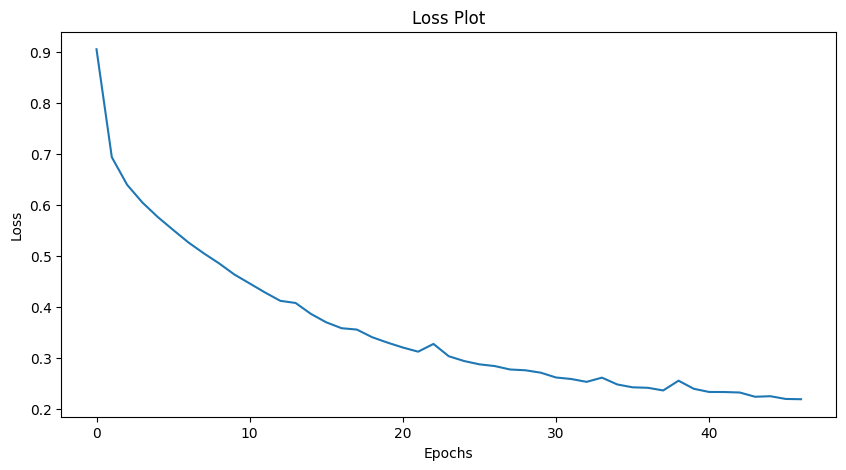

In [83]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### Train 7

In [98]:
%%time
EPOCHS = 10
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for batch, (img_tensor, target) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec\n')

    # Save checkpoint every 5 epochs and after the last epoch if it's not a multiple of 5
    if (epoch + 1) % 5 == 0 or epoch + 1 == EPOCHS:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved at {ckpt_save_path} at epoch {epoch+1}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.2186
Epoch 1 Batch 100 Loss 0.2524
Epoch 1 Batch 200 Loss 0.2119
Epoch 1 Batch 300 Loss 0.2340
Epoch 1 Batch 400 Loss 0.2310
Epoch 1 Batch 500 Loss 0.2007
Epoch 1 Batch 600 Loss 0.1999
Epoch 1 Batch 700 Loss 0.2203
Epoch 1 Batch 800 Loss 0.2550
Epoch 1 Batch 900 Loss 0.2335
Epoch 1 Batch 1000 Loss 0.2064
Epoch 1 Batch 1100 Loss 0.2215
Epoch 1 Batch 1200 Loss 0.1943
Epoch 1 Batch 1300 Loss 0.2202


 10%|█         | 1/10 [07:05<1:03:48, 425.35s/it]

Epoch 1 Loss 0.223533
Time taken for 1 epoch 425.35 sec

Epoch 2 Batch 0 Loss 0.2159
Epoch 2 Batch 100 Loss 0.1957
Epoch 2 Batch 200 Loss 0.2471
Epoch 2 Batch 300 Loss 0.1803
Epoch 2 Batch 400 Loss 0.1938
Epoch 2 Batch 500 Loss 0.2046
Epoch 2 Batch 600 Loss 0.2196
Epoch 2 Batch 700 Loss 0.2084
Epoch 2 Batch 800 Loss 0.1931
Epoch 2 Batch 900 Loss 0.2098
Epoch 2 Batch 1000 Loss 0.2196
Epoch 2 Batch 1100 Loss 0.2131
Epoch 2 Batch 1200 Loss 0.2089
Epoch 2 Batch 1300 Loss 0.3360


 20%|██        | 2/10 [14:09<56:35, 424.41s/it]  

Epoch 2 Loss 0.220318
Time taken for 1 epoch 423.76 sec

Epoch 3 Batch 0 Loss 0.3249
Epoch 3 Batch 100 Loss 0.2695
Epoch 3 Batch 200 Loss 0.2854
Epoch 3 Batch 300 Loss 0.2582
Epoch 3 Batch 400 Loss 0.2440
Epoch 3 Batch 500 Loss 0.2464
Epoch 3 Batch 600 Loss 0.2405
Epoch 3 Batch 700 Loss 0.2238
Epoch 3 Batch 800 Loss 0.2474
Epoch 3 Batch 900 Loss 0.2482
Epoch 3 Batch 1000 Loss 0.2208
Epoch 3 Batch 1100 Loss 0.2091
Epoch 3 Batch 1200 Loss 0.2244
Epoch 3 Batch 1300 Loss 0.2207


 30%|███       | 3/10 [20:53<48:27, 415.42s/it]

Epoch 3 Loss 0.239007
Time taken for 1 epoch 404.73 sec

Epoch 4 Batch 0 Loss 0.2636
Epoch 4 Batch 100 Loss 0.2182
Epoch 4 Batch 200 Loss 0.2409
Epoch 4 Batch 300 Loss 0.2468
Epoch 4 Batch 400 Loss 0.2423
Epoch 4 Batch 500 Loss 0.2393
Epoch 4 Batch 600 Loss 0.2096
Epoch 4 Batch 700 Loss 0.2041
Epoch 4 Batch 800 Loss 0.1764
Epoch 4 Batch 900 Loss 0.2485
Epoch 4 Batch 1000 Loss 0.2064
Epoch 4 Batch 1100 Loss 0.2245
Epoch 4 Batch 1200 Loss 0.2227
Epoch 4 Batch 1300 Loss 0.2529


 40%|████      | 4/10 [27:39<41:10, 411.72s/it]

Epoch 4 Loss 0.219261
Time taken for 1 epoch 406.04 sec

Epoch 5 Batch 0 Loss 0.2311
Epoch 5 Batch 100 Loss 0.2083
Epoch 5 Batch 200 Loss 0.2008
Epoch 5 Batch 300 Loss 0.2089
Epoch 5 Batch 400 Loss 0.2029
Epoch 5 Batch 500 Loss 0.2052
Epoch 5 Batch 600 Loss 0.1796
Epoch 5 Batch 700 Loss 0.1860
Epoch 5 Batch 800 Loss 0.1788
Epoch 5 Batch 900 Loss 0.1962
Epoch 5 Batch 1000 Loss 0.2088
Epoch 5 Batch 1100 Loss 0.1816
Epoch 5 Batch 1200 Loss 0.1822
Epoch 5 Batch 1300 Loss 0.1791
Epoch 5 Loss 0.203647
Time taken for 1 epoch 391.72 sec



 50%|█████     | 5/10 [34:11<33:42, 404.60s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-12 at epoch 5
Epoch 6 Batch 0 Loss 0.2088
Epoch 6 Batch 100 Loss 0.2005
Epoch 6 Batch 200 Loss 0.2334
Epoch 6 Batch 300 Loss 0.2090
Epoch 6 Batch 400 Loss 0.1975
Epoch 6 Batch 500 Loss 0.2005
Epoch 6 Batch 600 Loss 0.2080
Epoch 6 Batch 700 Loss 0.2317
Epoch 6 Batch 800 Loss 0.2138
Epoch 6 Batch 900 Loss 0.2028
Epoch 6 Batch 1000 Loss 0.2417
Epoch 6 Batch 1100 Loss 0.2027
Epoch 6 Batch 1200 Loss 0.2135
Epoch 6 Batch 1300 Loss 0.1952


 60%|██████    | 6/10 [56:23<47:59, 719.87s/it]

Epoch 6 Loss 0.206381
Time taken for 1 epoch 1331.87 sec

Epoch 7 Batch 0 Loss 0.2233
Epoch 7 Batch 100 Loss 0.2225
Epoch 7 Batch 200 Loss 0.2039
Epoch 7 Batch 300 Loss 0.2261
Epoch 7 Batch 400 Loss 0.2275
Epoch 7 Batch 500 Loss 0.1915
Epoch 7 Batch 600 Loss 0.2107
Epoch 7 Batch 700 Loss 0.1950
Epoch 7 Batch 800 Loss 0.1998
Epoch 7 Batch 900 Loss 0.2196
Epoch 7 Batch 1000 Loss 0.2068
Epoch 7 Batch 1100 Loss 0.2085
Epoch 7 Batch 1200 Loss 0.1842
Epoch 7 Batch 1300 Loss 0.1967


 70%|███████   | 7/10 [1:03:08<30:50, 616.86s/it]

Epoch 7 Loss 0.214397
Time taken for 1 epoch 404.79 sec

Epoch 8 Batch 0 Loss 0.2110
Epoch 8 Batch 100 Loss 0.1933
Epoch 8 Batch 200 Loss 0.1956
Epoch 8 Batch 300 Loss 0.3146
Epoch 8 Batch 400 Loss 0.2308
Epoch 8 Batch 500 Loss 0.2519
Epoch 8 Batch 600 Loss 0.1932
Epoch 8 Batch 700 Loss 0.2023
Epoch 8 Batch 800 Loss 0.1995
Epoch 8 Batch 900 Loss 0.2361
Epoch 8 Batch 1000 Loss 0.2165
Epoch 8 Batch 1100 Loss 0.2019
Epoch 8 Batch 1200 Loss 0.2037
Epoch 8 Batch 1300 Loss 0.1885


 80%|████████  | 8/10 [1:19:31<24:26, 733.41s/it]

Epoch 8 Loss 0.217924
Time taken for 1 epoch 982.95 sec

Epoch 9 Batch 0 Loss 0.3101
Epoch 9 Batch 100 Loss 0.2418
Epoch 9 Batch 200 Loss 0.2310
Epoch 9 Batch 300 Loss 0.2275
Epoch 9 Batch 400 Loss 0.1963
Epoch 9 Batch 500 Loss 0.2096
Epoch 9 Batch 600 Loss 0.2096
Epoch 9 Batch 700 Loss 0.1996
Epoch 9 Batch 800 Loss 0.2005
Epoch 9 Batch 900 Loss 0.2179
Epoch 9 Batch 1000 Loss 0.2049
Epoch 9 Batch 1100 Loss 0.1877
Epoch 9 Batch 1200 Loss 0.1729
Epoch 9 Batch 1300 Loss 0.2014


 90%|█████████ | 9/10 [1:26:11<10:29, 629.15s/it]

Epoch 9 Loss 0.212591
Time taken for 1 epoch 399.90 sec

Epoch 10 Batch 0 Loss 0.2072
Epoch 10 Batch 100 Loss 0.1905
Epoch 10 Batch 200 Loss 0.1946
Epoch 10 Batch 300 Loss 0.1834
Epoch 10 Batch 400 Loss 0.2126
Epoch 10 Batch 500 Loss 0.1998
Epoch 10 Batch 600 Loss 0.2018
Epoch 10 Batch 700 Loss 0.1886
Epoch 10 Batch 800 Loss 0.2206
Epoch 10 Batch 900 Loss 0.1911
Epoch 10 Batch 1000 Loss 0.1916
Epoch 10 Batch 1100 Loss 0.1976
Epoch 10 Batch 1200 Loss 0.2270
Epoch 10 Batch 1300 Loss 0.2277
Epoch 10 Loss 0.198841
Time taken for 1 epoch 399.64 sec



100%|██████████| 10/10 [1:32:51<00:00, 557.12s/it]

Checkpoint saved at checkpoints/bahdanau_2024-06-11_03-28-16_100000_256_512_15001_52_2/ckpt-13 at epoch 10
CPU times: user 1h 6min 30s, sys: 17min 7s, total: 1h 23min 38s
Wall time: 1h 32min 51s


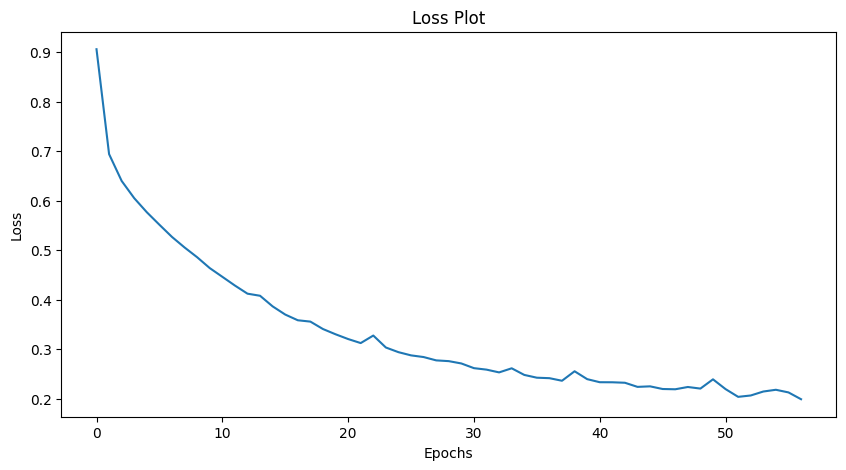

In [99]:
plt.figure(figsize=(10,5))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 8. Model Evaluation and Visualization

We provide functions to evaluate our model on new images, generate captions, and visualize attention weights to understand which parts of the image the model focuses on while generating each word in the caption.


### Inference and Attention Plotting functions

In [100]:
def evaluate(image_path):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Resetting the decoder state
    hidden = decoder.reset_state(batch_size=1)

    # Loading and processing the image
    temp_input = tf.expand_dims(load_image(image_path), 0)  # Correctly applying expand_dims
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Passing image through the encoder
    features = encoder(img_tensor_val)

    # Decoder setup
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image_path, result, attention_plot):
    temp_image = np.array(Image.open(image_path))
    len_result = len(result)
    
    # Calculate the number of rows and columns to fit the attention plots
    num_cols = 2  # You can adjust this number based on your preference
    num_rows = np.ceil(len_result / num_cols).astype(int)

    fig = plt.figure(figsize=(15, 2.5 * num_rows))  # Adjust figure size accordingly

    for i in range(len_result):
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        temp_att = np.resize(attention_plot[i], (8, 8))  # Assuming attention plot can be resized to 8x8
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


# def plot_attention(image, result, attention_plot):
#     temp_image = np.array(Image.open(image))

#     fig = plt.figure(figsize=(10, 10))

#     len_result = len(result)
#     for l in range(len_result):
#         temp_att = np.resize(attention_plot[l], (8, 8))
#         ax = fig.add_subplot(len_result//2, len_result//2, l+1)
#         ax.set_title(result[l])
#         img = ax.imshow(temp_image)
#         ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
#     plt.show()

In [101]:
def evaluate_and_show(image_path):
    # Displaying the image using previously defined show_image function
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img_id] if i not in [0]])
    real_caption = '<start> ' + real_caption + ' <end>'

    # Evaluate the image to generate caption and attention plot
    result, attention_plot = evaluate(image_path)

    prediction_caption = ' '.join(result)
    print('Real Caption:', real_caption)
    print('Prediction Caption:', prediction_caption)

    # Showing the image
    show_image(image_path, real_caption)

    # Displaying the attention plots
    plot_attention(image_path, result, attention_plot)

Real Caption: <start> <start> a person leaning against a fence with a giraffe <end> <end>
Prediction Caption: pink wandering a mat <end>
<start> <start> a person leaning against a fence with a giraffe <end> <end>


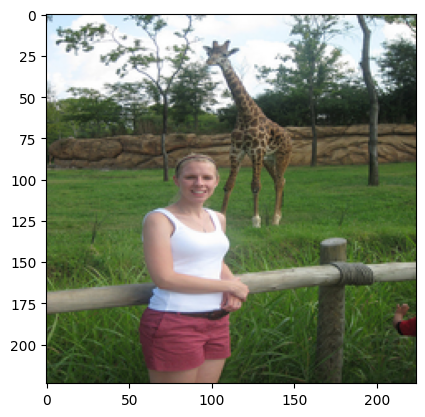

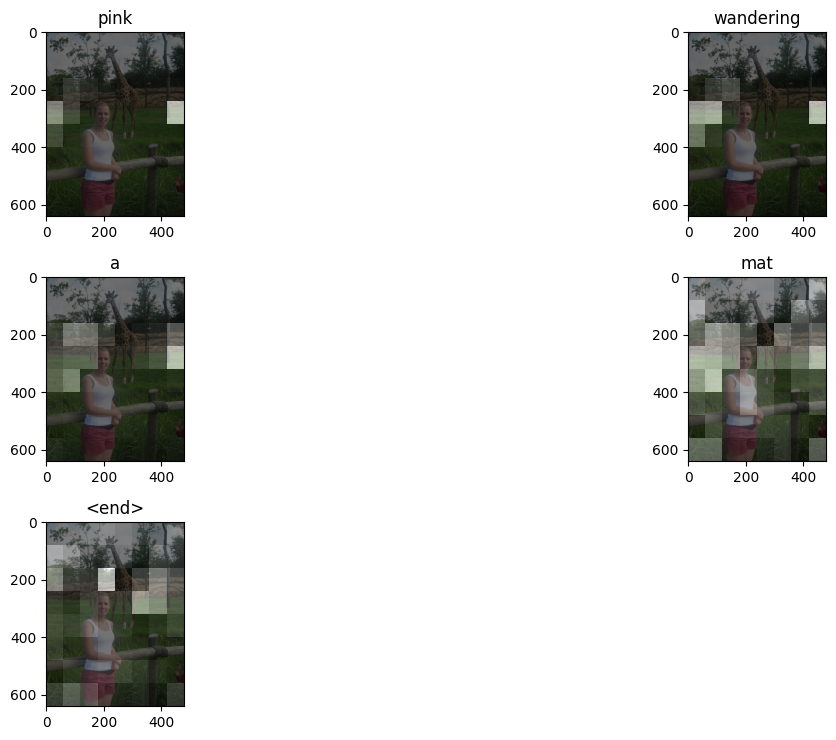

In [110]:
# Assuming img_id is an index to a specific image in the validation set
img_id = 250  # or any valid index into img_name_val
image_path = img_name_val[img_id]

# Function call
evaluate_and_show(image_path)